In [1]:
import requests
import os
from bs4 import BeautifulSoup
import pandas as pd

from IPython.display import display, Image

In [2]:
base_url = "https://www.goodreads.com"
genres_url = "https://www.goodreads.com/genres"

In [10]:
response = requests.get(genres_url)
response.status_code

200

# Initial exploration

First I will extract the genres of the books from the genres page

In [11]:
doc = BeautifulSoup(response.text, 'html.parser')

In [12]:
genre_tags = doc.find_all('div', class_="rightContainer")[0].find_all('a')

In [16]:
genre_names = [tag.text for tag in genre_tags][1:-1]
genre_links = [tag['href'] for tag in genre_tags][1:-1]

In [17]:
genre_links[:5], genre_names[:5]

(['/genres/art',
  '/genres/biography',
  '/genres/business',
  '/genres/chick-lit',
  '/genres/children-s'],
 ['Art', 'Biography', 'Business', 'Chick Lit', "Children's"])

Now I will append these genre links to the base url link which will help in extracting the most popular books of each genre. I will be using a dictionary to easily store them where the genre_names will be the keys and genre links will be the values for the dictionary.

In [18]:
# genre_links_dict = {name: base_url + link for (name, link) in zip(genre_names, genre_links)}
# genre_links_dict

In [19]:
len(genre_links)

40

By visiting the art genre page, it looks like the page contains the newly released books, giveaways books and the most popular books. I am interested about the most popular ones but on the page there are only limited amount of books shown so clicking on *more books* another page opened which include the full list of the most read/popular books of the art genre. This page is the most useful for my analysis. 

So, now let's start with art genre and look at the html for this page

Now let's update the genre links dict to account for the most read books

In [20]:
genre_links_dict = {name: genres_url + "/most_read" + link[7:] for (name, link) in zip(genre_names, genre_links)}

In [21]:
genre_links_dict

{'Art': 'https://www.goodreads.com/genres/most_read/art',
 'Biography': 'https://www.goodreads.com/genres/most_read/biography',
 'Business': 'https://www.goodreads.com/genres/most_read/business',
 'Chick Lit': 'https://www.goodreads.com/genres/most_read/chick-lit',
 "Children's": 'https://www.goodreads.com/genres/most_read/children-s',
 'Christian': 'https://www.goodreads.com/genres/most_read/christian',
 'Classics': 'https://www.goodreads.com/genres/most_read/classics',
 'Comics': 'https://www.goodreads.com/genres/most_read/comics',
 'Contemporary': 'https://www.goodreads.com/genres/most_read/contemporary',
 'Cookbooks': 'https://www.goodreads.com/genres/most_read/cookbooks',
 'Crime': 'https://www.goodreads.com/genres/most_read/crime',
 'Ebooks': 'https://www.goodreads.com/genres/most_read/ebooks',
 'Fantasy': 'https://www.goodreads.com/genres/most_read/fantasy',
 'Fiction': 'https://www.goodreads.com/genres/most_read/fiction',
 'Gay and Lesbian': 'https://www.goodreads.com/genres/mo

This looks kinda neat.

In [25]:
response = requests.get(genre_links_dict['Crime'])
crime_doc = BeautifulSoup(response.text, 'html.parser')

On inspecting I found that the coverWrapper class contains the book info such as the link to the book page, its title and image.

In [210]:
book_link = crime_doc.find_all('div', class_='coverWrapper')[99].a['href']
book_title = crime_doc.find_all('div', class_='coverWrapper')[99].img['alt']
book_img = crime_doc.find_all('div', class_='coverWrapper')[99].img['src']

The Woman in the Window


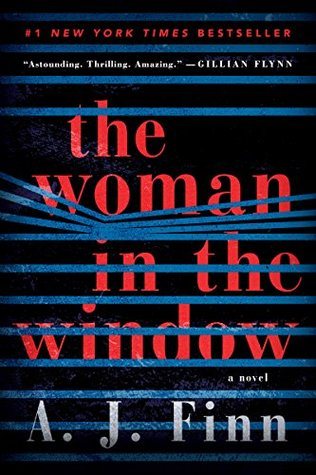

In [211]:
print(book_title)
display(Image(book_img, width=100))

Let's go to the book page to find out more about the book

In [32]:
book_url = base_url + book_link
book_url

'https://www.goodreads.com/book/show/53450790-the-perfect-marriage'

In [33]:
response = requests.get(book_url)
book_html = BeautifulSoup(response.text, 'html.parser')

In [76]:
len(book_html.text)

44825

The book page takes a lot of time to load so it would not be convenient to go through all the most read books in every single genre. Instead we can select a single book and do its analysis fully. We can extract the author, rating, reviews and analyze them.

## Analyzing a single book fully

The metadata contains info such as author, rating and number of reviews

In [231]:
author_name = book_html.find('div', class_= 'BookPageMetadataSection__contributor').text
print(f"Author: {author_name}")

AttributeError: 'NoneType' object has no attribute 'text'

In [114]:
book_score = book_html.find('div', class_= 'RatingStatistics__column').text
print(f"Score: {book_score}")

Score: 4.00


In [113]:
num_ratings, num_reviews = book_html.find('div', class_='RatingStatistics__meta')['aria-label'].split('and')
print(f"Number of ratings given: {num_ratings}")
print(f"Number of reviews given: {num_reviews}")

Number of ratings given: 392,809 ratings 
Number of reviews given:  30,626 reviews


In [120]:
book_desc = book_html.find('div', class_= 'BookPageMetadataSection__description').text
print(f"Description:\n\n {book_desc}")

Description:

 Would you defend your husband if he was accused of killing his mistress?Sarah Morgan is a successful and powerful defense attorney in Washington D.C. At 33 years old, she is a named partner at her firm and life is going exactly how she planned.The same cannot be said for her husband, Adam. He is a struggling writer who has had little success in his career. He begins to tire of his and Sarah’s relationship as she is constantly working. Out in the secluded woods, at Adam and Sarah’s second home, Adam engages in a passionate affair with Kelly Summers.Then, one morning everything changes. Adam is arrested for Kelly’s murder. She had been found stabbed to death in Adam and Sarah’s second home. Sarah soon finds herself playing the defender for her own husband, a man accused of murdering his mistress. But is Adam guilty or is he innocent?


In [142]:
num_pages, edition = book_html.find('div', class_= 'BookDetails').find_all('p')[0].text.split(',')
date_published = " ".join(book_html.find('div', class_= 'BookDetails').find_all('p')[1].text.split()[2:])
print(f"Number of pages: {num_pages}")
print(f"Edition: {edition}")
print(f"Publishing date: {date_published}")

Number of pages: 342 pages
Edition:  Paperback
Publishing date: July 3, 2020


In [143]:
author_profile = book_html.find('div', class_= 'FeaturedPerson__avatar').a['href']
author_profile

'https://www.goodreads.com/author/show/20309584.Jeneva_Rose'

Author profiles can be analyzed similarly. You just have to know how to extract the relevant tags from the html.

## Optional

Profile Image for Jeneva Rose.


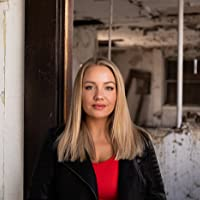

In [145]:
# optional
img_text = book_html.find('div', class_= 'FeaturedPerson__avatar').img['alt']
img = book_html.find('div', class_= 'FeaturedPerson__avatar').img['src']
print(img_text)
display(Image(img, width=100))

In [208]:
num_followers = book_html.find('div' ,class_='FeaturedPerson__infoPrimary').find_all('span')[-1].text.split()[0]
print(f"Number of followers of {author_name}: {num_followers}")

Number of followers of Jeneva Rose: 7,520


In [209]:
num_books = book_html.find('div' ,class_='FeaturedPerson__infoPrimary').find_all('span')[-2].text.split()[0]
print(f"Number of books written by {author_name}: {num_books}")

Number of books written by Jeneva Rose: 9


In [328]:
book_html.find('div', class_= 'RatingsHistogram__labelTotal')['aria-label'],\
[x.text for x in book_html.find_all('div', class_= 'RatingsHistogram__labelTitle')],\
[x.text for x in book_html.find_all('div', class_= 'RatingsHistogram__labelTotal')]

('Number of ratings and percentage of total ratings',
 ['5 stars', '4 stars', '3 stars', '2 stars', '1 star'],
 ['5,895 (47%)', '3,900 (31%)', '1,868 (15%)', '414 (3%)', '287 (2%)'])

### Reviews

In [373]:
book_html.find_all('article', class_= 'ReviewCard')[0]['aria-label']

'Review by Vickie'

In [376]:
book_html.find_all('section', class_= 'ReviewCard__content')[0].a.text

'May 1, 2023'

In [381]:
book_html.find_all('section', class_= 'ReviewCard__content')[0].span['aria-label']

'Rating 5 out of 5'

In [369]:
book_html.find_all('section', class_= 'ReviewText__content')[0].text

"This beautifully written book is about a mother and her daughter at a crucial point in both of their lives. It's a story of coping with grief and learning how to go on with life and how to rely on other people to help you through difficult times in life.Dani is an artist and has just learned that due to an eye disease, she'll be losing her vision in the future. Her life is in turmoil, her ex-husband (but still good friend) has just died in a car accident and she's working to help her daughter Bella cope with life without her dad in it. Dani decides to move from their home in the Outer Banks of NC to an inland farm near the Virginia border and she's taking Bella away from the only home that she's ever known. Bella feels betrayed - not only does she have to learn to navigate life without her father but she's left behind all of her friends and the comfort of a home she loved. Most of the time, instead of lashing out at her mother, she stuffs her feelings inside and works to present a cal

## Combining all of it

### Book info

In [283]:
# Helper functions
# Returns a dictionary containing information about the book given its html
def get_book_metadata(book_html):
    
    book_title = book_html.find('div', class_='BookPageTitleSection').text
    author_name = book_html.find('div', class_= 'BookPageMetadataSection__contributor').text
    book_score = book_html.find('div', class_= 'RatingStatistics__column').text
    num_ratings, num_reviews = book_html.find('div', class_='RatingStatistics__meta')['aria-label'].split('and')
    book_desc = book_html.find('div', class_= 'BookPageMetadataSection__description').text
    num_pages, edition = book_html.find('div', class_= 'BookDetails').find_all('p')[0].text.split(',')
    date_published = " ".join(book_html.find('div', class_= 'BookDetails').find_all('p')[1].text.split()[2:])
    
    book_info = {'Title': book_title,
                 'Author': author_name,
                 'Score': book_score,
                 'Num_ratings': num_ratings,
                 'Num_reviews': num_reviews,
                 'Num_pages': num_pages,
                 'Edition': edition,
                 'Publishing_date': date_published,
                 'Description': book_desc}
    
    return book_info

# Display information about the book from the dictionary
def display_book(book, book_img):
    print(book['Title'])
    display(Image(book_img, width=100))
    print(f"Author: {book['Author']}")
    print(f"Score : {book['Score']} out of 5")
    print(f"Number of ratings given: {book['Num_ratings']}")
    print(f"Number of reviews given: {book['Num_reviews']}")
    print(f"\nDescription of the book:\n\n {book['Description']}\n")
    print(f"Number of pages: {book['Num_pages']}")
    print(f"Edition: {book['Edition']}")
    print(f"Publishing date: {book['Publishing_date']}")

In [284]:
# Most important function
# Displays all the information about a book listed on the book's page
def get_book_info(book_url):
    r = requests.get(book_url)
    book_html = BeautifulSoup(r.text, 'html.parser')
    book_img = book_html.find('img', class_='ResponsiveImage')['src']
    
    book = get_book_metadata(book_html)
    display_book(book, book_img)

In [ ]:
get_book_info()

### Find books by genre and rank

In [288]:
def get_books_by_rank(genre_doc, rank):  
    '''
    Get book info about a book ranked among the given genre
    '''
    book_link = genre_doc.find_all('div', class_='coverWrapper')[rank-1].a['href']
    book_url = base_url + book_link
    print(f"Rank #{rank} ")    
    get_book_info(book_url)

In [289]:
def get_books_by_genre(genre_links_dict, genre, rank):
    '''
    Get any book from any genre by popularity i.e. rank
    '''
    genre_link = genre_links_dict[genre]
    response = requests.get(genre_link)
    genre_doc = BeautifulSoup(response.text, 'html.parser')
    print(f"Most popular books from the {genre} genre")   
    get_books_by_rank(genre_doc, rank)

Let's get the top ranked book from the science fiction genre

Rank: 1
The Midnight Library


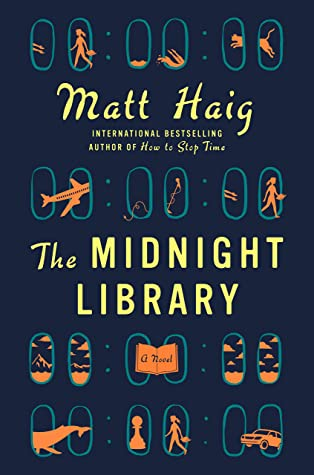

Author: Matt Haig
Score : 4.01 out of 5
Number of ratings given: 1,417,215 ratings 
Number of reviews given:  152,766 reviews

Description of the book:

 Between life and death there is a library, and within that library, the shelves go on forever. Every book provides a chance to try another life you could have lived. To see how things would be if you had made other choices . . . Would you have done anything different, if you had the chance to undo your regrets? A novel about all the choices that go into a life well lived.Somewhere out beyond the edge of the universe there is a library that contains an infinite number of books, each one the story of another reality. One tells the story of your life as it is, along with another book for the other life you could have lived if you had made a different choice at any point in your life. While we all wonder how our lives might have been, what if you had the chance to go to the library and see for yourself? Would any of these other lives trul

In [287]:
get_books_by_genre(genre_links_dict, genre='Science Fiction', rank=1)

## Finding most shelved books by genre (for kaggle)

Exploring the most popular books. Have to change the urls again ):

In [291]:
print(genre_names[-9:])

['Science', 'Science Fiction', 'Self Help', 'Suspense', 'Spirituality', 'Sports', 'Thriller', 'Travel', 'Young Adult']


Let's start with the mystery genre

In [292]:
genre_most_popular_dict = {name: base_url + "/shelf/show" + link[7:] for (name, link) in zip(genre_names, genre_links)}
genre_most_popular_dict

{'Art': 'https://www.goodreads.com/shelf/show/art',
 'Biography': 'https://www.goodreads.com/shelf/show/biography',
 'Business': 'https://www.goodreads.com/shelf/show/business',
 'Chick Lit': 'https://www.goodreads.com/shelf/show/chick-lit',
 "Children's": 'https://www.goodreads.com/shelf/show/children-s',
 'Christian': 'https://www.goodreads.com/shelf/show/christian',
 'Classics': 'https://www.goodreads.com/shelf/show/classics',
 'Comics': 'https://www.goodreads.com/shelf/show/comics',
 'Contemporary': 'https://www.goodreads.com/shelf/show/contemporary',
 'Cookbooks': 'https://www.goodreads.com/shelf/show/cookbooks',
 'Crime': 'https://www.goodreads.com/shelf/show/crime',
 'Ebooks': 'https://www.goodreads.com/shelf/show/ebooks',
 'Fantasy': 'https://www.goodreads.com/shelf/show/fantasy',
 'Fiction': 'https://www.goodreads.com/shelf/show/fiction',
 'Gay and Lesbian': 'https://www.goodreads.com/shelf/show/gay-and-lesbian',
 'Graphic Novels': 'https://www.goodreads.com/shelf/show/graphic

Let's analyze some thriller books from the thriller url

In [298]:
thriller_url = genre_most_popular_dict['Thriller']
response = requests.get(thriller_url)
doc = BeautifulSoup(response.text, 'html.parser')

In [294]:
# doc.find_all('div', class_='left')[0].text.strip().split('\n')

In [299]:
# All book tags from the thriller genre
book_tags = doc.find_all('div', class_="left")

In [300]:
book_tags[0]

<div class="left" style="width: 75%;">
<a class="leftAlignedImage" href="/book/show/19288043-gone-girl" title="Gone Girl"><img alt="Gone Girl" src="https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1554086139l/19288043._SY75_.jpg"/></a>
<a class="bookTitle" href="/book/show/19288043-gone-girl">Gone Girl (Paperback)</a>
<br/>
<span class="by">by</span>
<span itemprop="author" itemscope="" itemtype="http://schema.org/Person">
<div class="authorName__container">
<a class="authorName" href="https://www.goodreads.com/author/show/2383.Gillian_Flynn" itemprop="url"><span itemprop="name">Gillian Flynn</span></a> <span class="greyText">(Goodreads Author)</span>
</div>
</span>


              (shelved 9076 times as <em>thriller</em>)     

              <br/>
<span class="greyText smallText">
                avg rating 4.12 —
                2,900,791 ratings  —
                published 2012
              </span>
</div>

In [301]:
book_titles = [tag.find_all('a')[0]['title'] for tag in book_tags]
book_titles[:5]

['Gone Girl',
 'The Girl on the Train',
 'The Silent Patient',
 'The Da Vinci Code (Robert Langdon, #2)',
 'The Girl with the Dragon Tattoo (Millennium, #1)']

Looks like thriller authors are obsessed with girls. Anyway let's analyze further

In [302]:
book_urls = [base_url + tag.find_all('a')[0]['href'] for tag in book_tags]
book_urls[:5]

['https://www.goodreads.com/book/show/19288043-gone-girl',
 'https://www.goodreads.com/book/show/22557272-the-girl-on-the-train',
 'https://www.goodreads.com/book/show/40097951-the-silent-patient',
 'https://www.goodreads.com/book/show/968.The_Da_Vinci_Code',
 'https://www.goodreads.com/book/show/2429135.The_Girl_with_the_Dragon_Tattoo']

In [303]:
book_imgs = [tag.find('img')['src'] for tag in book_tags]

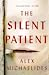

In [333]:
display(Image(book_imgs[2], width=70))

In [308]:
author_links = [tag.find_all('a')[2]['href'] for tag in book_tags]
author_links[:5]

['https://www.goodreads.com/author/show/2383.Gillian_Flynn',
 'https://www.goodreads.com/author/show/1063732.Paula_Hawkins',
 'https://www.goodreads.com/author/show/17621440.Alex_Michaelides',
 'https://www.goodreads.com/author/show/630.Dan_Brown',
 'https://www.goodreads.com/author/show/706255.Stieg_Larsson']

In [309]:
author_names = [tag.find('span', itemprop="name").text for tag in book_tags]
author_names[:5]

['Gillian Flynn',
 'Paula Hawkins',
 'Alex Michaelides',
 'Dan Brown',
 'Stieg Larsson']

In [310]:
scores_list, ratings_list, year_published_list = [], [], []
for tag in book_tags:
    score, num_ratings, year_published = tag.find('span', class_="greyText smallText").text.strip().split('\n')
    score = score.strip()[11:15]
    num_ratings = "".join(num_ratings.strip().split(','))[:-3]
    year_published = [x for x in year_published.strip().split() if x.isdigit()][0]
    scores_list.append(score)
    ratings_list.append(num_ratings)
    year_published_list.append(year_published)

In [311]:
print(f"Top 5 books scores: {scores_list[:5]}")
print(f"Top 5 books ratings: {ratings_list[:5]}")
print(f"Top 5 books publishing year: {year_published_list[:5]}")

Top 5 books scores: ['4.12', '3.96', '4.18', '3.90', '4.16']
Top 5 books ratings: ['2900791 ratings', '2756615 ratings', '1609324 ratings', '2261954 ratings', '3048676 ratings']
Top 5 books publishing year: ['2012', '2015', '2019', '2003', '2005']


Combining all of the above together we can make a dictionary for each of the books depicting its title, url, author, scores etc. This way it will be easy to lookup info about any book

In [312]:
ranks = [*range(1, len(book_tags)+1)]

In [313]:
book_info_dicts = []
for (title, author, score, num_ratings, year_published) in \
zip(book_titles, author_names, scores_list, ratings_list, year_published_list):
    book_info =  {'Title': title, 
                  'Author': author, 
                  'Score': score, 
                  'Num_ratings': num_ratings, 
                  'Year_published': year_published}
    book_info_dicts.append(book_info)

In [314]:
book_info_dicts

[{'Title': 'Gone Girl',
  'Author': 'Gillian Flynn',
  'Score': '4.12',
  'Num_ratings': '2900791 ratings',
  'Year_published': '2012'},
 {'Title': 'The Girl on the Train',
  'Author': 'Paula Hawkins',
  'Score': '3.96',
  'Num_ratings': '2756615 ratings',
  'Year_published': '2015'},
 {'Title': 'The Silent Patient',
  'Author': 'Alex Michaelides',
  'Score': '4.18',
  'Num_ratings': '1609324 ratings',
  'Year_published': '2019'},
 {'Title': 'The Da Vinci Code (Robert Langdon, #2)',
  'Author': 'Dan Brown',
  'Score': '3.90',
  'Num_ratings': '2261954 ratings',
  'Year_published': '2003'},
 {'Title': 'The Girl with the Dragon Tattoo (Millennium, #1)',
  'Author': 'Stieg Larsson',
  'Score': '4.16',
  'Num_ratings': '3048676 ratings',
  'Year_published': '2005'},
 {'Title': 'Angels & Demons (Robert Langdon, #1)',
  'Author': 'Dan Brown',
  'Score': '3.93',
  'Num_ratings': '3088958 ratings',
  'Year_published': '2000'},
 {'Title': 'Verity',
  'Author': 'Colleen Hoover',
  'Score': '4.35

In [315]:
thriller_df = pd.DataFrame(book_info_dicts, index=ranks)

In [318]:
thriller_df.sort_values('Num_ratings', ascending=False)[:10]

,Title,Author,Score,Num_ratings,Year_published
8,Sharp Objects,Gillian Flynn,4.01,944094 ratings,2006
33,"Jurassic Park (Jurassic Park, #1)",Michael Crichton,4.08,919613 ratings,1990
9,"The Girl Who Played with Fire (Millennium, #2)",Stieg Larsson,4.25,896577 ratings,2006
11,The Guest List,Lucy Foley,3.83,828210 ratings,2020
31,"One of Us Is Lying (One of Us is Lying, #1)",Karen M. McManus,3.96,725282 ratings,2017
10,The Woman in the Window,A.J. Finn,3.96,722432 ratings,2018
12,The Girl Who Kicked the Hornet's Nest (Millenn...,Stieg Larsson,4.23,714802 ratings,2007
13,Dark Places,Gillian Flynn,3.95,708116 ratings,2009
22,A Good Girl's Guide to Murder (A Good Girl's G...,Holly Jackson,4.34,669271 ratings,2019
20,Deception Point,Dan Brown,3.75,652930 ratings,2001


In [329]:
# thriller_df['Score'] = thriller_df['Score'].astype('float')
# thriller_df.info()

In [330]:
# thriller_df.groupby('Author')['Title'].count().sort_values(ascending=False)

In [327]:
# Helper functions
def get_book_metadata(book_tag):
    book_title = book_tag.find_all('a')[0]['title']
    book_url = base_url + book_tag.find_all('a')[0]['href'] 
    
    book_img = book_tag.find('img')['src']
#     display(Image(book_img, width=70))

    author_link = book_tag.find_all('a')[2]['href']
    author_name = book_tag.find('span', itemprop="name").text
    
    score, num_ratings, year_published = book_tag.find('span', class_="greyText smallText").text.strip().split('\n')
    score = score.strip()[11:15]
    num_ratings = "".join(num_ratings.strip().split(','))[:-3]
    year_published = [x for x in year_published.strip().split() if x.isdigit()][0]
    
    book_info = {'Title': book_title,
                 'Author': author_name,
                 'Score': score,
                 'Num_ratings': num_ratings,
                 'Year_published': year_published}
    
    return book_info

In [328]:
def get_popular_books(genre):
    url = genre_most_popular_dict[genre]
    response = requests.get(url)
    doc = BeautifulSoup(response.text, 'html.parser')
    
    book_tags = doc.find_all('div', class_="left")
    book_metadata_list = [get_book_metadata(tag) for tag in book_tags]
    
    ranks = [*range(1, len(book_tags)+1)]
    genre_df = pd.DataFrame(book_metadata_list, index=ranks)
    
    return genre_df

In [331]:
get_popular_books(genre='Manga')

,Title,Author,Score,Num_ratings,Year_published
1,"Death Note, Vol. 1: Boredom (Death Note, #1)",Tsugumi Ohba,4.46,280645 ratings,2004
2,"Fruits Basket, Vol. 1",Natsuki Takaya,4.28,183465 ratings,1999
3,"Fullmetal Alchemist, Vol. 1 (Fullmetal Alchemi...",Hiromu Arakawa,4.52,156136 ratings,2002
4,"Attack on Titan, Vol. 1 (Attack on Titan, #1)",Hajime Isayama,4.47,220058 ratings,2010
5,"Black Butler, Vol. 1 (Black Butler, #1)",Yana Toboso,4.36,126353 ratings,2007
6,"Naruto, Vol. 1: Uzumaki Naruto (Naruto, #1)",Masashi Kishimoto,4.41,196292 ratings,1999
7,"Bleach, Vol. 1 (Bleach, #1)",Tite Kubo,4.25,170347 ratings,2002
8,"Ouran High School Host Club, Vol. 1 (Ouran Hig...",Bisco Hatori,4.38,173371 ratings,2003
9,"Confluence (Death Note, #2)",Tsugumi Ohba,4.47,48130 ratings,2004
10,"My Hero Academia, Vol. 1",Kohei Horikoshi,4.38,107577 ratings,2014
